In [23]:
import sompy
from sompy.visualization.hitmap import HitMapView
from sompy.visualization.umatrix import UMatrixView
from sompy.visualization.bmuhits import BmuHitsView

from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm      

from python_speech_features import mfcc

from sklearn.externals import joblib

import hmm_model_feature_extraction

import random

import matplotlib.pyplot as plt

gcp = False

In [24]:
"""

TOPOGRAPHIC ERROR: One of the primary goals of the SOM algorithm is to preserve the topological
features of the input space in the low dimensional output space. Topographic error
(TE) is a measure of how well the structure of the input space is modeled by the
map. Specifically, it evaluates the local discontinuities in the mapping [3]. TE is
calculated by finding the best-matching and second-best-matching neuron in the
map for each input and then evaluating the positions. If the nodes are next to
each other, then we say topology has been preserved for this input. If not, then
this is counted as an error. The total number of errors divided by the total number
of data points gives the topographic error of the map. 

QUANTIZATION ERROR: Based on the signaling processing concept of the same name, quantization
error (QE) is a measure of the average distance between the data points and the
map nodes to which they are mapped, with smaller values indicating a better fit.
Kohonen suggested QE as the basic quality measure for evaluating self-organizing
maps.

U-MATRIX: The U-matrix is also a heatmap but can be interpreted like a topographic map 
(a map that shows the elevation contours across a region) across our SOM grid. The ‘hills’ (darker colors) 
in the U-matrix represent large distances between neighbors and vice versa for valleys. The U-Matrix is 
used to visualise multidimensional clusters in 2D (the weighted distances between neurons approximate the
topology of the data).

"""

'\n\nTOPOGRAPHIC ERROR: One of the primary goals of the SOM algorithm is to preserve the topological\nfeatures of the input space in the low dimensional output space. Topographic error\n(TE) is a measure of how well the structure of the input space is modeled by the\nmap. Specifically, it evaluates the local discontinuities in the mapping [3]. TE is\ncalculated by finding the best-matching and second-best-matching neuron in the\nmap for each input and then evaluating the positions. If the nodes are next to\neach other, then we say topology has been preserved for this input. If not, then\nthis is counted as an error. The total number of errors divided by the total number\nof data points gives the topographic error of the map. \n\nQUANTIZATION ERROR: Based on the signaling processing concept of the same name, quantization\nerror (QE) is a measure of the average distance between the data points and the\nmap nodes to which they are mapped, with smaller values indicating a better fit.\nKoho

In [25]:
"""
ADDITIONAL CONFIGURATIONS BASED ON COMPUTE LOCATION
"""

if gcp == True:
    
    import gcsfs
    import pickle
    import cupy
    
    # specify gcs bucket
    bucket_name = "ad-bucket-15730"
    # set cloud based mixed dir
    gcs_mixed_dir = "gs://{}/mixed_20k".format(bucket_name)
    # set cloud based hmm model dir
    gcs_hmm_model_dir = "gs://{}/hmm_models".format(bucket_name)
    # set cloud based validation dir
    gcs_validation_dir = "gs://{}/validation".format(bucket_name)
    # set local, vm-based mixed dir
    local_mixed_dir = "mixed_local"
    # set local, vm-based validation dir
    local_validation_dir = "validation_local"
    # initialize gcsfs object
    fs = gcsfs.GCSFileSystem(project = 'audio-detection-1')
    metadata = pd.read_csv(gcs_mixed_dir + "/mixed_metadata.csv")
	
    # enable gpus for pomegranate
    pomegranate.utils.enable_gpu()
    print("communicating with GPU: ", pomegranate.utils.is_gpu_enabled())
    
    ### moving pre-populated validation and training set ###
    ### for faster model validation ###
    
    # need to create folder on vm instance for validation set
    if "validation_local" not in os.listdir():
        
        os.mkdir("validation_local")
        
    # need to create folder on vm instance for training (mixed) set 
    if "mixed_local" not in os.listdir():
        
        os.mkdir("mixed_local")
        
    # if fewer then ten (arbitrary) files, copy all in from gcs   
    if len(os.listdir("validation_local")) < 10:
        
        os.system("gsutil -m cp {}/* ./{}".format(gcs_validation_dir, local_validation_dir))
        
    # if fewer then ten (arbitrary) files, copy all in from gcs    
    if len(os.listdir("mixed_local")) < 10:
        
        os.system("gsutil -m cp {}/* ./{}".format(gcs_mixed_dir, local_mixed_dir))

    
else:
    
    # configuration when not running on the cloud
    local_mixed_dir = "../../../mixed"
    local_hmm_model_dir = "../../../hmm_models"
    metadata = pd.read_csv(local_mixed_dir + "/mixed_metadata.csv")

In [26]:
### initialize feature extraction class ###
# mixed_dir will depend on whether we are pulling from gcs or locally
# sampling_freq will depend on how we initially processed our audio files
# gcs will depend on whether we want to pull from gcs during training or from local directory
fe = hmm_model_feature_extraction.feature_extraction(mixed_dir=local_mixed_dir, sampling_freq = 20000, gcs = False)

# labels we're dealing with

metadata['class'].value_counts()

dog_bark            3000
street_music        3000
engine_idling       3000
air_conditioner     3000
drilling            3000
children_playing    3000
jackhammer          3000
siren               2787
car_horn            1287
gun_shot            1122
Name: class, dtype: int64

# gun_shot

In [32]:
# create an empty array for appending features
train = metadata[metadata['class'] == "gun_shot"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1))

X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

In [33]:
# confirm shape is tractable for SOM: 100 - 200K

X.shape

(183862, 13)

In [34]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)

 Training...
 pca_linear_initialization took: 0.324000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  8.245000, quantization error: 2.357996

 epoch: 2 ---> elapsed time:  8.303000, quantization error: 2.257732

 epoch: 3 ---> elapsed time:  8.234000, quantization error: 2.156295

 epoch: 4 ---> elapsed time:  10.463000, quantization error: 2.097149

 epoch: 5 ---> elapsed time:  11.381000, quantization error: 2.048622

 epoch: 6 ---> elapsed time:  10.311000, quantization error: 2.001360

 epoch: 7 ---> elapsed time:  12.981000, quantization error: 1.949951

 epoch: 8 ---> elapsed time:  15.179000, quantization error: 1.892887

 epoch: 9 ---> elapsed time:  7.762000, quantization error: 1.829510

 epoch: 10 ---> elapsed time:  12.214000, quantization error: 1.757647

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  11.035000, quantization error: 1.67

In [35]:
# check topographical error: ideally less than .20

som.calculate_topographic_error()

0.17244455080440765

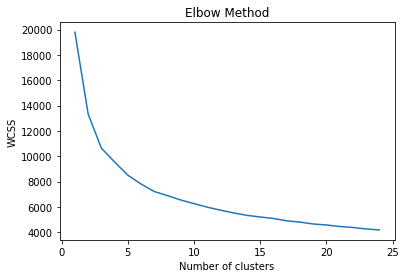

In [36]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


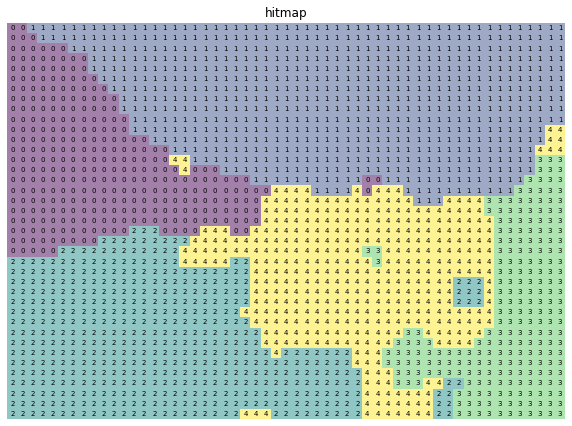

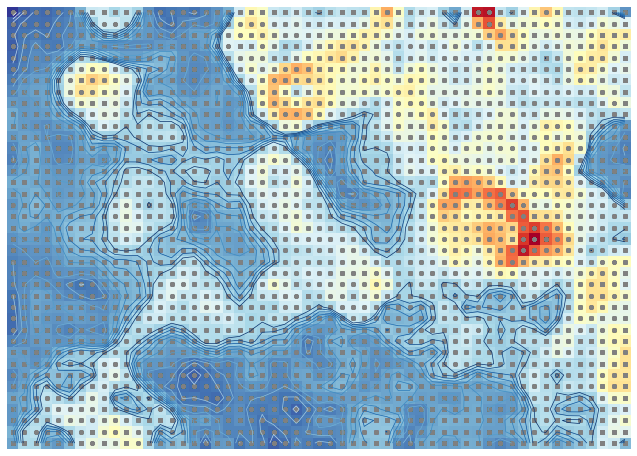

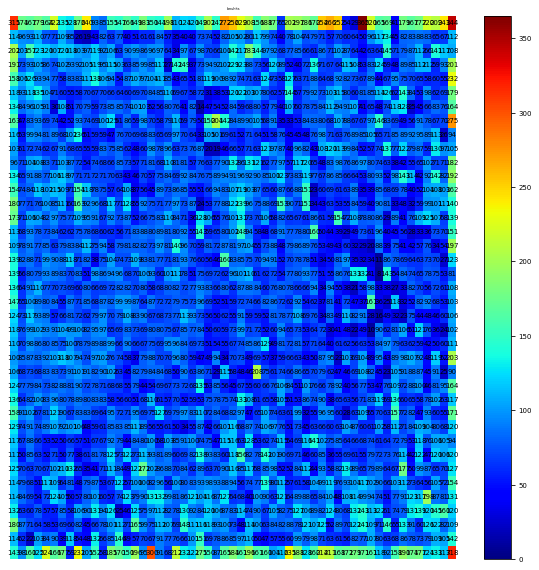

In [37]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation: 

40kHz: Worth exploring 6-7 hidden states. 

20kHz: 15 hidden states.

# air_conditioner

In [39]:
# create an empty array for appending features
train = metadata[metadata['class'] == "air_conditioner"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(170622, 13)

In [40]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.231000 seconds
 Rough training...
 radius_ini: 8.000000 , radius_final: 2.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  3.312000, quantization error: 2.498977

 epoch: 2 ---> elapsed time:  3.356000, quantization error: 2.457536

 epoch: 3 ---> elapsed time:  3.498000, quantization error: 2.343704

 epoch: 4 ---> elapsed time:  5.317000, quantization error: 2.257699

 epoch: 5 ---> elapsed time:  3.083000, quantization error: 2.191681

 epoch: 6 ---> elapsed time:  3.067000, quantization error: 2.124703

 epoch: 7 ---> elapsed time:  2.983000, quantization error: 2.054663

 epoch: 8 ---> elapsed time:  2.803000, quantization error: 1.978090

 epoch: 9 ---> elapsed time:  2.833000, quantization error: 1.887486

 epoch: 10 ---> elapsed time:  4.609000, quantization error: 1.777146

 Finetune training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  6.735000, quantization error: 1.661079

 

0.15058433261830245

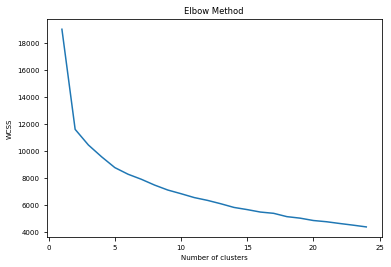

In [41]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


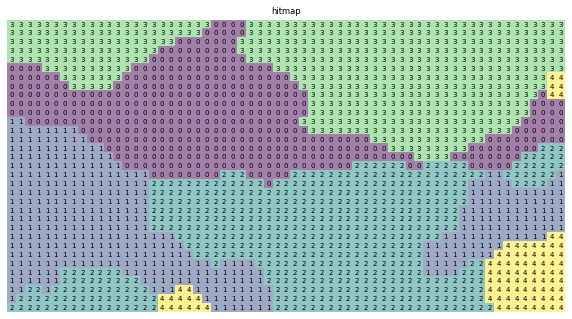

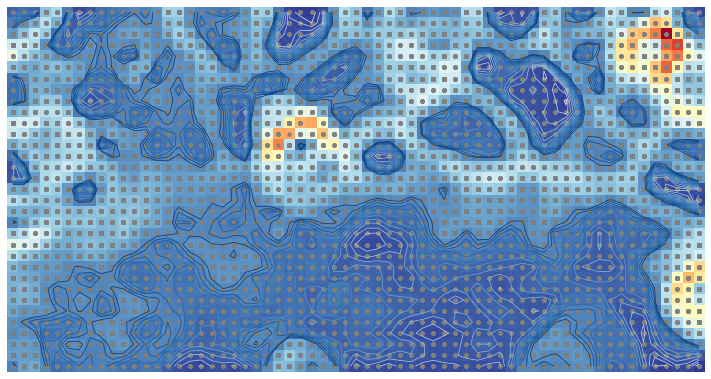

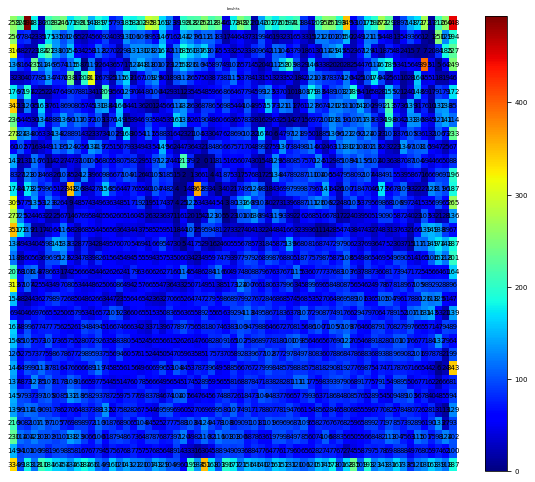

In [42]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation: 

Performing best with 20 States

40kHz: 12-15 Hidden States

20kHz: 9 Hidden States

# siren

In [43]:
# create an empty array for appending features
train = metadata[metadata['class'] == "siren"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(156616, 13)

In [44]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.218000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.585000, quantization error: 2.475120

 epoch: 2 ---> elapsed time:  2.672000, quantization error: 2.461073

 epoch: 3 ---> elapsed time:  2.446000, quantization error: 2.406257

 epoch: 4 ---> elapsed time:  2.789000, quantization error: 2.314751

 epoch: 5 ---> elapsed time:  2.646000, quantization error: 2.243510

 epoch: 6 ---> elapsed time:  2.531000, quantization error: 2.183927

 epoch: 7 ---> elapsed time:  3.923000, quantization error: 2.124489

 epoch: 8 ---> elapsed time:  5.101000, quantization error: 2.064785

 epoch: 9 ---> elapsed time:  2.476000, quantization error: 1.999654

 epoch: 10 ---> elapsed time:  2.436000, quantization error: 1.922179

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.619000, quantization error: 1.827064

 

0.134092302191347

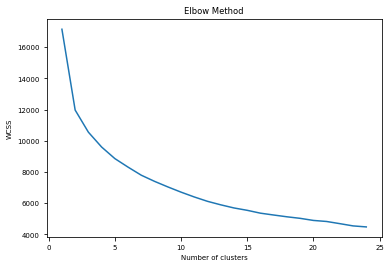

In [45]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


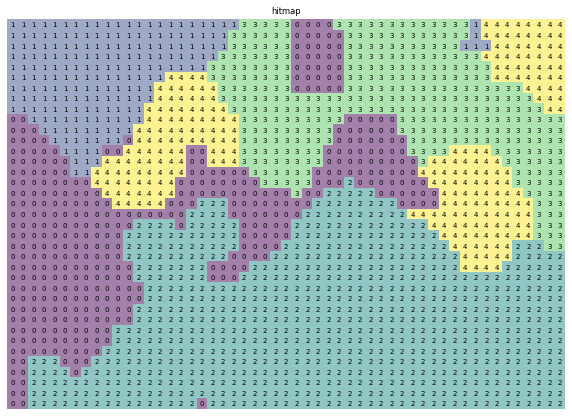

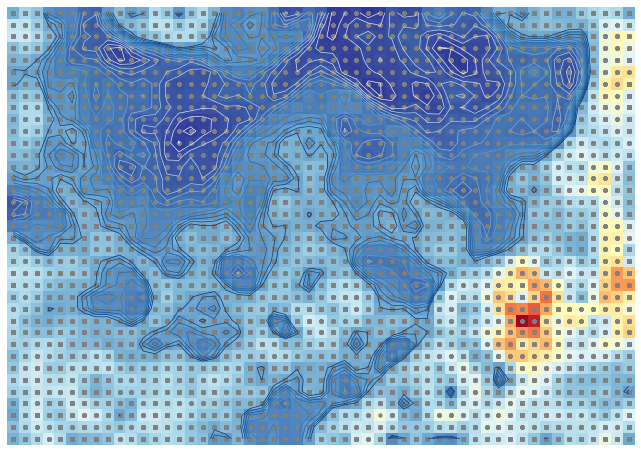

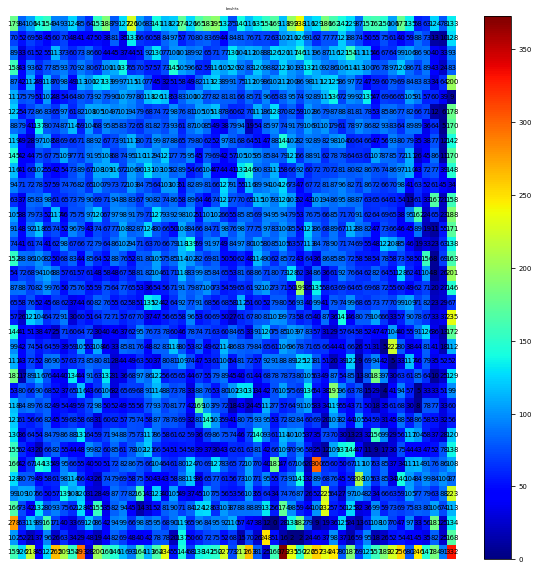

In [46]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing better with sufficient iterations at 17


40kHz: 6-7

20kHz: 10

# drilling

In [47]:
# create an empty array for appending features
train = metadata[metadata['class'] == "drilling"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(150484, 13)

In [48]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.206000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.153000, quantization error: 2.695090

 epoch: 2 ---> elapsed time:  3.007000, quantization error: 2.616456

 epoch: 3 ---> elapsed time:  2.451000, quantization error: 2.500457

 epoch: 4 ---> elapsed time:  2.408000, quantization error: 2.428860

 epoch: 5 ---> elapsed time:  2.377000, quantization error: 2.368028

 epoch: 6 ---> elapsed time:  2.391000, quantization error: 2.306811

 epoch: 7 ---> elapsed time:  5.900000, quantization error: 2.241797

 epoch: 8 ---> elapsed time:  2.548000, quantization error: 2.170422

 epoch: 9 ---> elapsed time:  2.470000, quantization error: 2.087946

 epoch: 10 ---> elapsed time:  2.523000, quantization error: 1.988890

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.449000, quantization error: 1.869650

 

0.1693070359639563

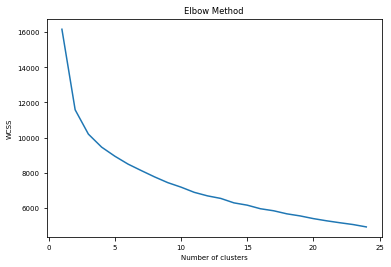

In [49]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


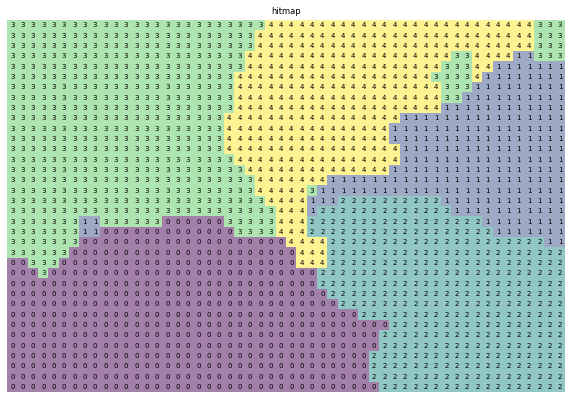

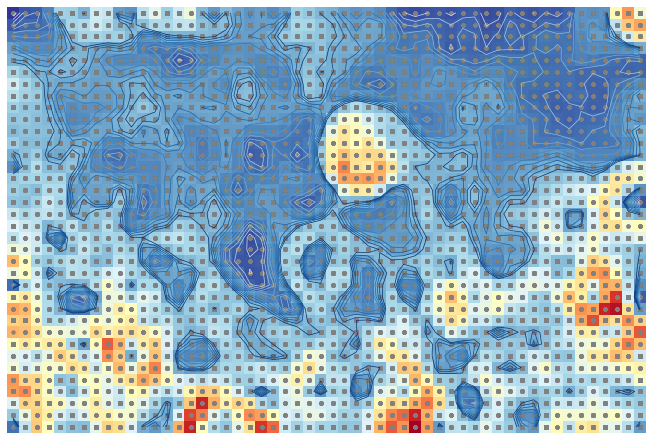

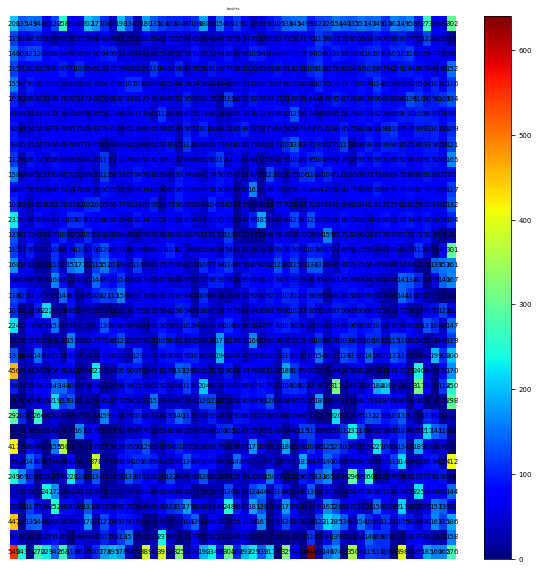

In [50]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing better with 20

40kHz: Try 9-10

20kHz: 21

# jackhammer

In [51]:
# create an empty array for appending features
train = metadata[metadata['class'] == "jackhammer"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(149952, 13)

In [52]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.199000 seconds
 Rough training...
 radius_ini: 8.000000 , radius_final: 2.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  1.891000, quantization error: 2.603436

 epoch: 2 ---> elapsed time:  1.889000, quantization error: 2.601556

 epoch: 3 ---> elapsed time:  1.923000, quantization error: 2.479627

 epoch: 4 ---> elapsed time:  1.892000, quantization error: 2.397710

 epoch: 5 ---> elapsed time:  1.912000, quantization error: 2.345683

 epoch: 6 ---> elapsed time:  1.958000, quantization error: 2.294441

 epoch: 7 ---> elapsed time:  2.016000, quantization error: 2.241493

 epoch: 8 ---> elapsed time:  2.011000, quantization error: 2.184369

 epoch: 9 ---> elapsed time:  1.881000, quantization error: 2.120901

 epoch: 10 ---> elapsed time:  2.067000, quantization error: 2.046313

 Finetune training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.278000, quantization error: 1.954971

 

0.1433725458813487

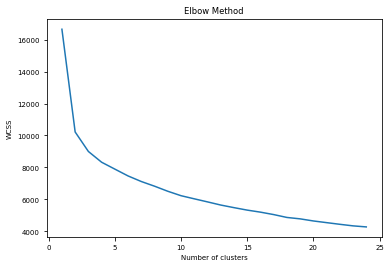

In [53]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


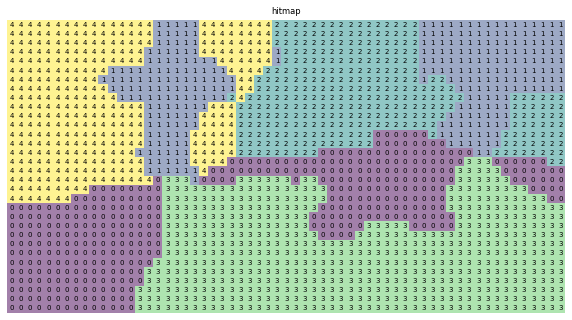

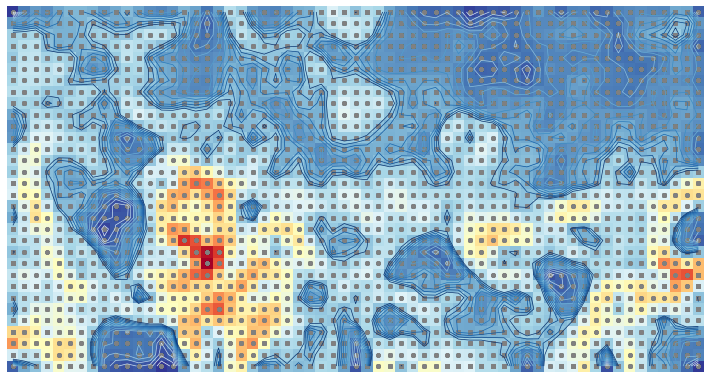

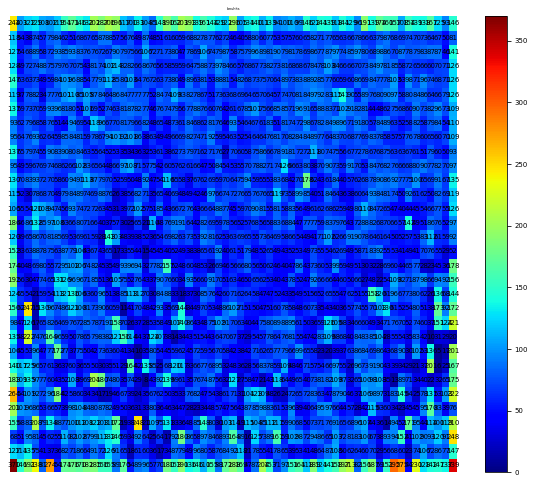

In [54]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing well at 18

40kHz: 9-10

20kHz: 20



# children_playing

In [55]:
# create an empty array for appending features
train = metadata[metadata['class'] == "children_playing"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(168856, 13)

In [56]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.237000 seconds
 Rough training...
 radius_ini: 8.000000 , radius_final: 2.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  5.289000, quantization error: 2.487076

 epoch: 2 ---> elapsed time:  6.652000, quantization error: 2.499754

 epoch: 3 ---> elapsed time:  4.059000, quantization error: 2.444853

 epoch: 4 ---> elapsed time:  3.881000, quantization error: 2.364538

 epoch: 5 ---> elapsed time:  4.702000, quantization error: 2.289106

 epoch: 6 ---> elapsed time:  2.926000, quantization error: 2.232409

 epoch: 7 ---> elapsed time:  3.626000, quantization error: 2.181466

 epoch: 8 ---> elapsed time:  4.710000, quantization error: 2.129529

 epoch: 9 ---> elapsed time:  2.819000, quantization error: 2.072821

 epoch: 10 ---> elapsed time:  4.246000, quantization error: 2.009128

 Finetune training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  3.308000, quantization error: 1.934042

 

0.16196640924811673

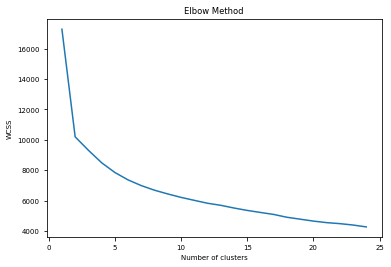

In [57]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


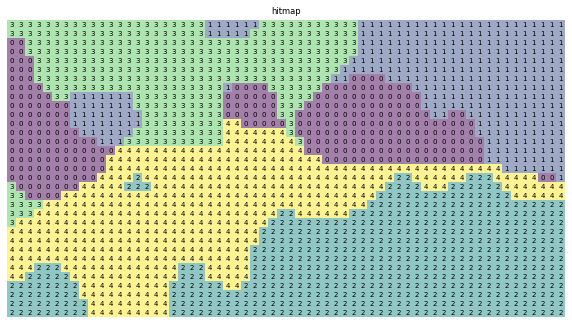

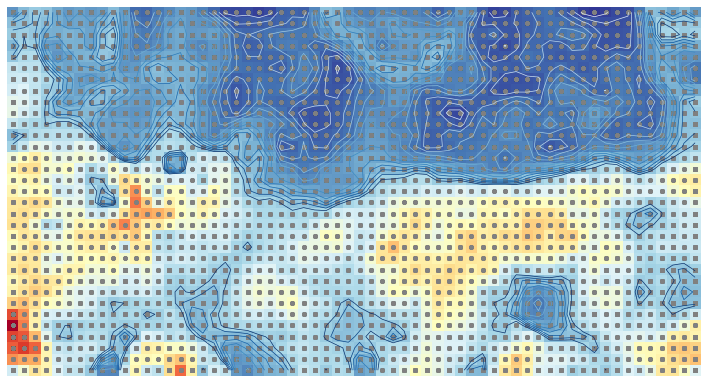

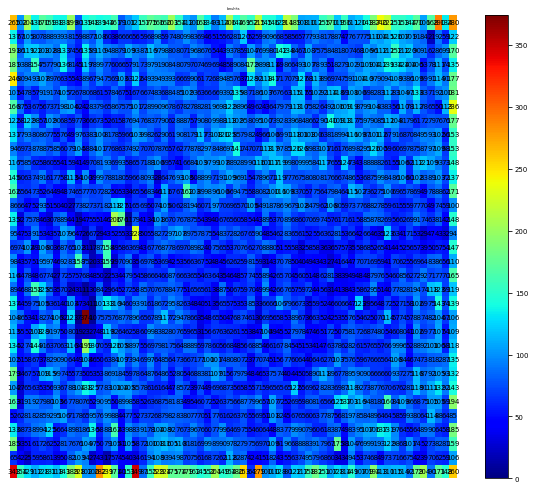

In [58]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Not performing well on multivariate - check window sizes

40kHz: 9-10

20khZ: 14

# engine_idling

In [59]:
# create an empty array for appending features
train = metadata[metadata['class'] == "engine_idling"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(167488, 13)

In [60]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.242000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  4.691000, quantization error: 2.464753

 epoch: 2 ---> elapsed time:  4.925000, quantization error: 2.384414

 epoch: 3 ---> elapsed time:  4.378000, quantization error: 2.258191

 epoch: 4 ---> elapsed time:  6.385000, quantization error: 2.160517

 epoch: 5 ---> elapsed time:  4.796000, quantization error: 2.077122

 epoch: 6 ---> elapsed time:  4.769000, quantization error: 2.012603

 epoch: 7 ---> elapsed time:  4.875000, quantization error: 1.951107

 epoch: 8 ---> elapsed time:  4.564000, quantization error: 1.885094

 epoch: 9 ---> elapsed time:  5.709000, quantization error: 1.810827

 epoch: 10 ---> elapsed time:  4.528000, quantization error: 1.727766

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  4.485000, quantization error: 1.632653

 

0.1591397592663355

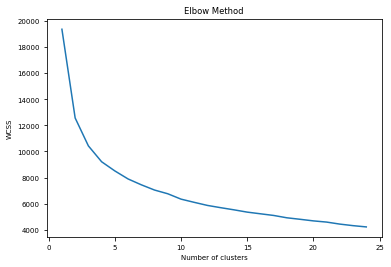

In [61]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


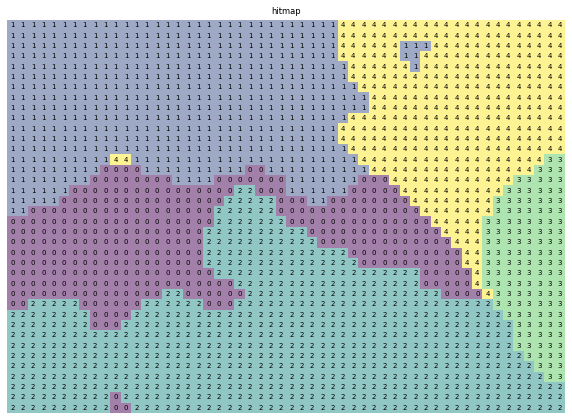

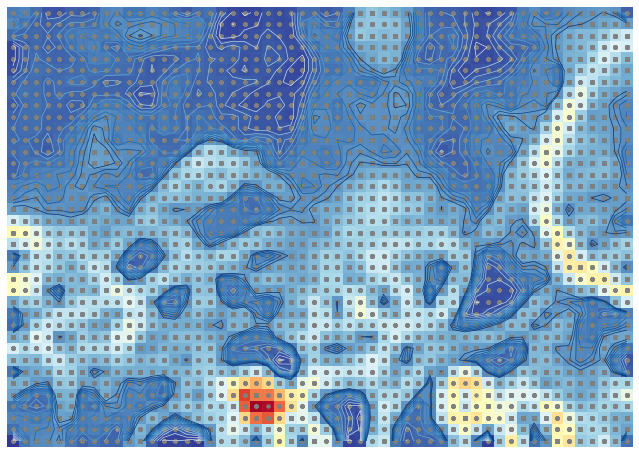

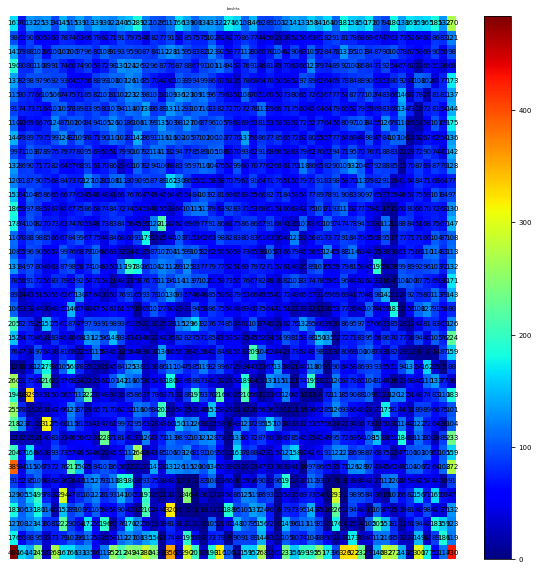

In [62]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing well wth 20

40kHz: 10-12

20kHz: 10-11

# street_music

In [63]:
# create an empty array for appending features
train = metadata[metadata['class'] == "street_music"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(170772, 13)

In [64]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.227000 seconds
 Rough training...
 radius_ini: 8.000000 , radius_final: 2.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  6.220000, quantization error: 2.554098

 epoch: 2 ---> elapsed time:  5.721000, quantization error: 2.561966

 epoch: 3 ---> elapsed time:  4.988000, quantization error: 2.513005

 epoch: 4 ---> elapsed time:  4.854000, quantization error: 2.450336

 epoch: 5 ---> elapsed time:  4.852000, quantization error: 2.369408

 epoch: 6 ---> elapsed time:  5.630000, quantization error: 2.297722

 epoch: 7 ---> elapsed time:  4.955000, quantization error: 2.240479

 epoch: 8 ---> elapsed time:  4.811000, quantization error: 2.186970

 epoch: 9 ---> elapsed time:  5.365000, quantization error: 2.130891

 epoch: 10 ---> elapsed time:  5.020000, quantization error: 2.067807

 Finetune training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  4.434000, quantization error: 1.989345

 

0.165788302532031

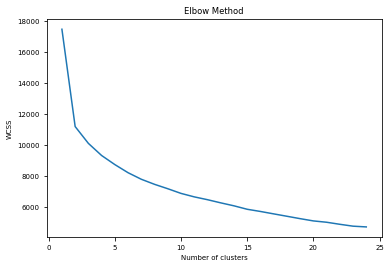

In [65]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


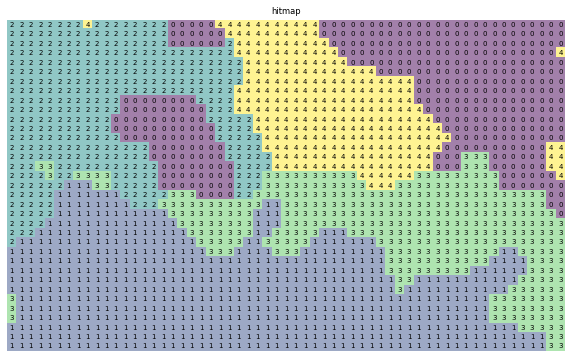

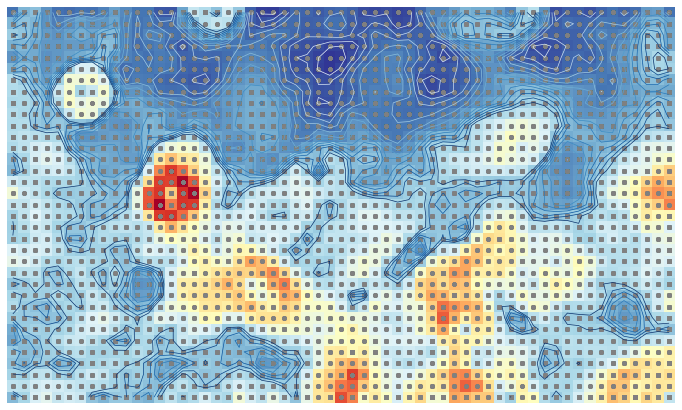

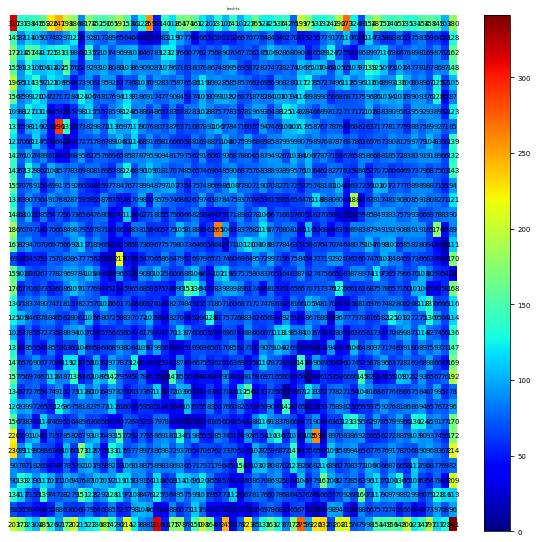

In [66]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing better with 17

40kHz: Try 7-8

20kHz: 14

# dog_bark

In [67]:
# create an empty array for appending features
train = metadata[metadata['class'] == "dog_bark"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(133165, 13)

In [68]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.183000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  1.519000, quantization error: 2.447970

 epoch: 2 ---> elapsed time:  1.766000, quantization error: 2.408932

 epoch: 3 ---> elapsed time:  1.681000, quantization error: 2.324775

 epoch: 4 ---> elapsed time:  1.698000, quantization error: 2.245307

 epoch: 5 ---> elapsed time:  1.795000, quantization error: 2.183815

 epoch: 6 ---> elapsed time:  1.580000, quantization error: 2.135299

 epoch: 7 ---> elapsed time:  1.547000, quantization error: 2.089281

 epoch: 8 ---> elapsed time:  1.620000, quantization error: 2.041969

 epoch: 9 ---> elapsed time:  1.612000, quantization error: 1.990504

 epoch: 10 ---> elapsed time:  1.669000, quantization error: 1.930503

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  2.091000, quantization error: 1.849013

 

0.21252581383997296

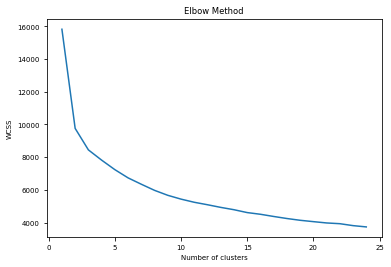

In [69]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


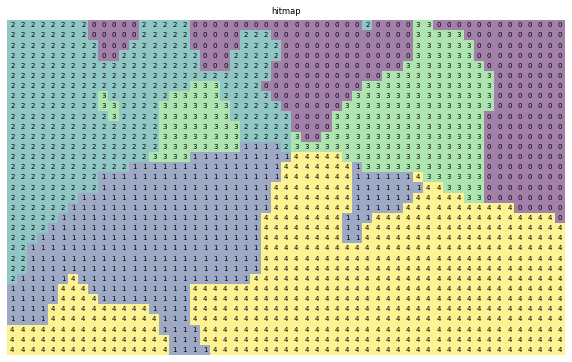

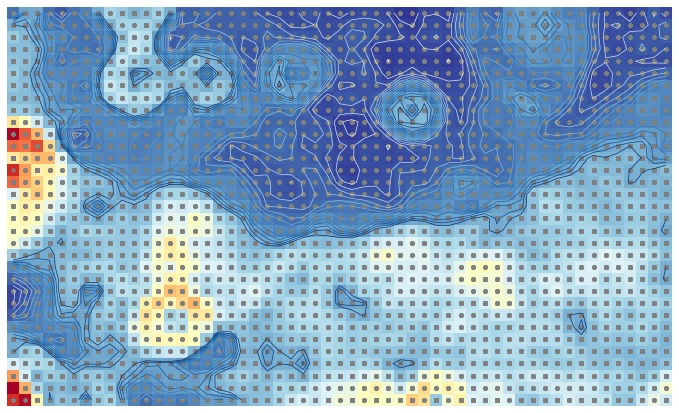

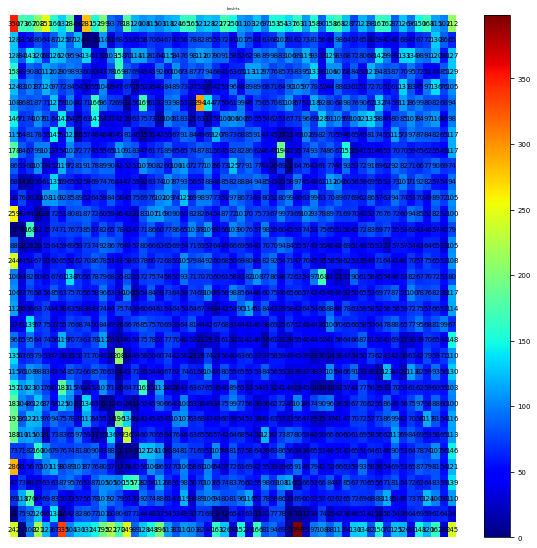

In [70]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Performing well with 17

40kHz: Try 4-6

20kHz: 12


# car_horn

In [71]:
# create an empty array for appending features
train = metadata[metadata['class'] == "car_horn"]['slice_file_name'].tolist()
# randomly select fraction of sample
train = random.sample(train, int(len(train) * 1/7))
X = np.array([])
    
for j in range(len(train)):
        
    loaded = fe.read(train[j])
    mfcc_features = fe.return_mfcc(loaded)

    if len(X) == 0:
                
        X = mfcc_features
            
    else:
                
        X = np.append(X, mfcc_features, axis=0)

# confirm shape is tractable for SOM: 100 - 200K

X.shape        

(45918, 13)

In [72]:
# build som instance
som = sompy.SOMFactory().build(X, normalization = 'var', initialization='pca') 
# let sompy choose the mapsize
mapsize = som.calculate_map_size('rect')
# rebuild with map size
som = sompy.SOMFactory().build(X, mapsize = mapsize, normalization = 'var', initialization='pca') 
# train
som.train(n_job=-1, verbose='info', train_rough_len=10, train_finetune_len=10)
# check topographical error: ideally less than .20
som.calculate_topographic_error()

 Training...
 pca_linear_initialization took: 0.065000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.250000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.380000, quantization error: 2.654824

 epoch: 2 ---> elapsed time:  0.363000, quantization error: 2.577110

 epoch: 3 ---> elapsed time:  0.373000, quantization error: 2.443912

 epoch: 4 ---> elapsed time:  0.356000, quantization error: 2.346529

 epoch: 5 ---> elapsed time:  0.385000, quantization error: 2.276586

 epoch: 6 ---> elapsed time:  0.357000, quantization error: 2.209327

 epoch: 7 ---> elapsed time:  0.364000, quantization error: 2.144211

 epoch: 8 ---> elapsed time:  0.358000, quantization error: 2.080191

 epoch: 9 ---> elapsed time:  0.368000, quantization error: 2.013021

 epoch: 10 ---> elapsed time:  0.362000, quantization error: 1.937408

 Finetune training...
 radius_ini: 1.250000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.373000, quantization error: 1.844400

 

0.14462737924125615

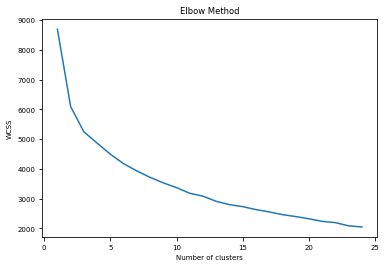

In [73]:
# create elbow plot applying kmeans cluster to the node weight vectors

codebook = som.codebook.matrix

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(codebook)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/Users/chrisolen/anaconda3/lib/python3.7/site-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


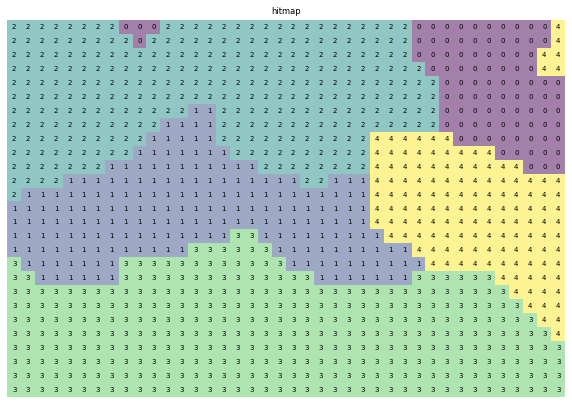

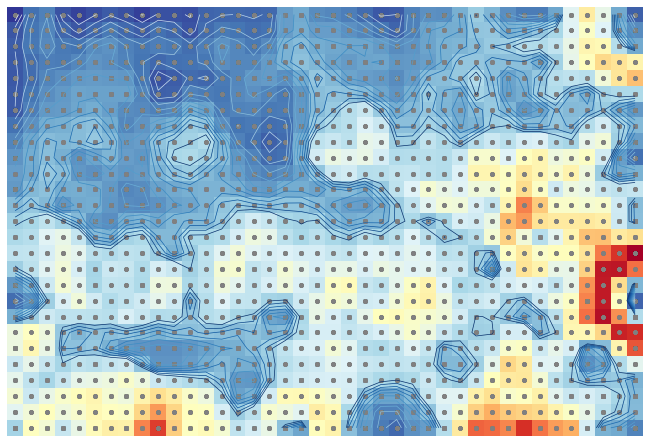

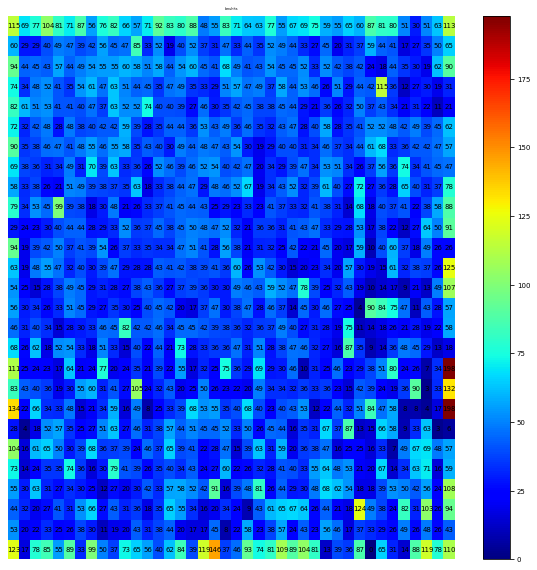

In [74]:
# plot hitmap, umatrix, and bmumap

"""
The ‘hills’ in the U-matrix represent large distances between neighbors and vice versa for valleys.

"""

som.cluster(5)

h = HitMapView(10, 10, 'hitmap')
u = UMatrixView(10, 10, "umatrix", text_size=7, labels=True, )
b = BmuHitsView(10, 10, "bmuhits", text_size=7)


x = h.show(som)
y = u.show(som)
z = b.show(som)



### Recommendation:

Struggling between 12 an 18

40kHz: 10-12

20kHz: 14